# Investigating the DNN based electron ID

This study uses a flattened ntuple containing the DNN scores for individual electrons (along with other variables which I am ignoring for now). The input files from which these flat ntuples are produced are MiniAOD samples from the Run3Winter22 campaign (`CMSSW_12_2_3_patch1`).

The DNN-ID for the electrons is based on the following scores of a multiclassifier.
```
'dnn_signal_Isolated'
'dnn_signal_nonIsolated'
'dnn_bkg_nonIsolated'
'dnn_bkg_Tau'
'dnn_bkg_Photon'
```

The MVA scores used in this study are the following.
```
'Fall17IsoV2Vals'
'Fall17IsoV2RawVals'
'RunIIIWinter22IsoV1Vals'
'RunIIIWinter22IsoV1RawVals'
```

These variables in the ntuple are produced using the following script. This he ntuple maker runs in a `CMSSW_13_0_8` environment which has the new RunIII MVA scores. 

**ntuple maker:** <a href="https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/test/testElectronMVA_cfg.py">GitHub: cmssw/RecoEgamma/ElectronIdentification/test
/testElectronMVA_cfg.py</a> 

#### The goal of this study is to compare these scores with the MVA scores.

### Reading the input files as dataframes:

In [1]:
import os, sys
import uproot
filedy = uproot.open('inputs/Run3Winter22/ntuple_DYJetsToLL_M-50.root')
filett = uproot.open('inputs/Run3Winter22/ntuple_TTToSemiLeptonic.root')
#filetau = uproot.open('inputs/Run3Winter22/electron_ntuple_TauGun_Pt-15to500.root')
print('The input files are read using uproot.')

The input files are read using uproot.


In [2]:
import pandas as pd
import numpy as np

treedy = filedy['ntuplizer/tree']
treett = filett['ntuplizer/tree']
#treetau= filetau['ntuplizer/tree']

branches = [
    'ele_pt', 'ele_eta',
    'matchedToGenEle', #flag for deciding whether it is a signal or background electron 
    'dnn_signal_Isolated', 'dnn_signal_nonIsolated', 'dnn_bkg_nonIsolated', 'dnn_bkg_Tau', 'dnn_bkg_Photon', #DNN scores
    'Fall17IsoV2Vals', 'Fall17IsoV2RawVals', #MVA IDs from Run2
    'RunIIIWinter22IsoV1Vals', 'RunIIIWinter22IsoV1RawVals' #MVA IDs from Run3
]

#Turning the branches into awkward arrays, then into dataframes:
def make_df(tree, branches, samplename):
    awkarray = tree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['sample'] = samplename
    return df
    
dfdy = make_df(treedy, branches, 'drellyan')
dftt = make_df(treett, branches, 'ttbar')
#dftau = make_df(treetau, branches, 'taugun')

#The final dataframe containing everything:
#This is I you decide which samples I want to add
df=pd.concat([dfdy, dftt])

#renaming columns for my convenience:
rename = {
    'dnn_signal_Isolated':'score1',
    'dnn_signal_nonIsolated':'score2',
    'dnn_bkg_nonIsolated':'score3',
    'dnn_bkg_Tau':'score4',
    'dnn_bkg_Photon':'score5',
    'matchedToGenEle':'genmatch',
    'Fall17IsoV2Vals':'MVA1',
    'Fall17IsoV2RawVals':'MVA2',
    'RunIIIWinter22IsoV1Vals':'MVA3',
    'RunIIIWinter22IsoV1RawVals':'MVA4'
}

#Reversing this dictionary for later use
alias = {value: key for key, value in rename.items()}

df.rename(columns = rename, inplace = True)

#Let's normalize the variables from 0 to 1
def normalize_col(df, col):
    if df[col].max() != df[col].min():
        df[col] = (df[col]-df[col].min()) / (df[col].max()-df[col].min())
    else:
        print('Scaling error: max and min are the same!')
    return df

#Only the MVA scores require normalization
df=normalize_col(df, 'MVA1')
df=normalize_col(df, 'MVA2')
df=normalize_col(df, 'MVA3')
df=normalize_col(df, 'MVA4')

df

,ele_pt,ele_eta,genmatch,score1,score2,score3,score4,score5,MVA1,MVA2,MVA3,MVA4,sample
0,23.468096,-0.283136,1,0.983659,0.008065,0.000005,0.000094,0.008177,1.000000,0.817180,0.942862,1.000000,drellyan
1,38.110344,-2.358157,1,0.260119,0.016909,0.002410,0.020484,0.700078,0.998880,0.652914,0.770765,0.994859,drellyan
2,37.137051,1.352818,1,0.981787,0.002894,0.000031,0.000818,0.014470,1.000000,0.822732,0.907102,0.999999,drellyan
3,34.101891,0.131789,1,0.973500,0.005390,0.000334,0.014623,0.006152,1.000000,0.826741,0.854205,0.999990,drellyan
4,49.188972,0.983590,1,0.986205,0.000394,0.000049,0.003050,0.010301,1.000000,0.817444,0.917704,0.999999,drellyan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35019,47.635365,0.055639,1,0.990730,0.000244,0.000027,0.002194,0.006805,1.000000,0.877404,0.941204,1.000000,ttbar
35020,27.655937,0.141672,1,0.956910,0.036240,0.000077,0.000339,0.006434,1.000000,0.854936,0.934956,1.000000,ttbar
35021,11.539068,-1.829632,0,0.000897,0.212722,0.690918,0.094804,0.000660,0.000133,0.328743,0.109394,0.000002,ttbar
35022,8.311454,0.878375,0,0.000315,0.009595,0.711670,0.277606,0.000814,0.000044,0.306080,0.172462,0.000001,ttbar


### Defining signal and background electrons:

The variable, `matchedToGenEle` contains integers, which mean the following things:

- 0: The candidate does not match to any gen-electron. (fake)
- 1: The candidate is a prompt, real electron; matches to gen-electron.
- 2: The candidate is a prompt, gen-matched electron decaying from a tau (not part of a jet).
- 3: The candidate is a real electron, but not isolated.

The signal electrons have `matchedToGenEle == 1 OR 2`<br>
The backgrounds have `matchedToGenEle == 0 OR 3`

In [3]:
sig_flag = (df['genmatch'] == 1) | (df['genmatch'] == 2)
bkg_flag = (df['genmatch'] == 0) | (df['genmatch'] == 3)

df.loc[sig_flag, 'truth'] = 1
df.loc[bkg_flag, 'truth'] = 0

#Randomizing rows:
df = df.sample(frac=1) #randomizing rows
df.reset_index(inplace=True, drop=True)

def print_info(df, samplename):
    num = df[df["sample"] == samplename].shape[0]
    nsig =df[(df["sample"]==samplename)&(df["truth"]==1)].shape[0]
    nbkg =df[(df["sample"]==samplename)&(df["truth"]==0)].shape[0]
    if num!= 0:
        sig_frac = nsig*100/num
        bkg_frac = nbkg*100/num
    else:
        sig_frac = -1
        bkg_frac = -1
    print(f'Sample : {samplename}; \tnCandidates = {num}; '+
          f'nsig = {nsig} ({sig_frac:.1f}%), nbkg = {nbkg} ({bkg_frac:.1f}%)')
    
print_info(df, 'drellyan')
print_info(df, 'ttbar')
#print_info(df, 'taugun')

Sample : drellyan; 	nCandidates = 19557; nsig = 15357 (78.5%), nbkg = 4200 (21.5%)
Sample : ttbar; 	nCandidates = 35024; nsig = 9985 (28.5%), nbkg = 25039 (71.5%)


### DNN scores:

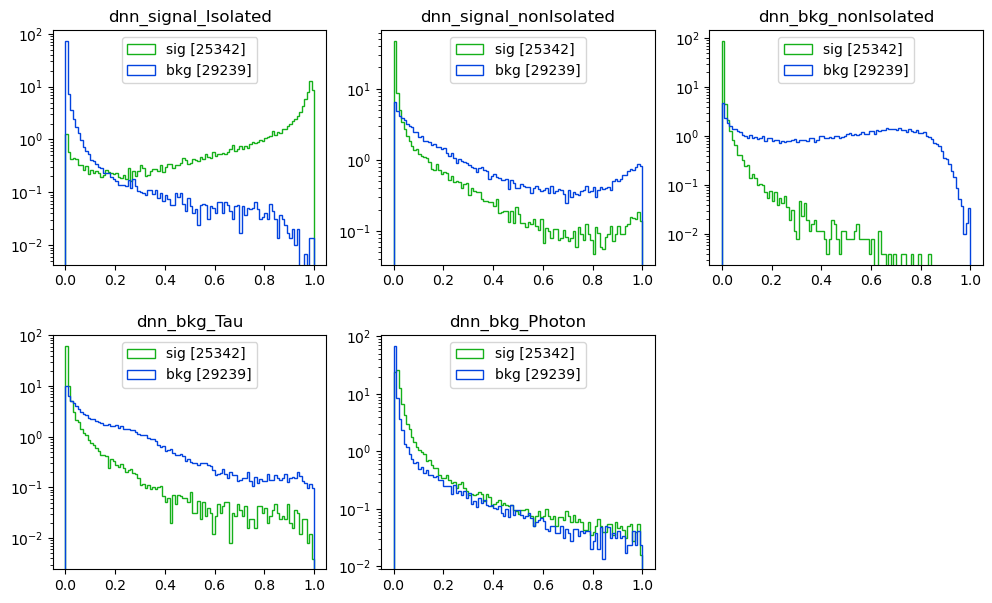

In [4]:
os.system('mkdir -p plots')

import matplotlib as mpl
import matplotlib.pyplot as plt

nsig=df[df['truth']==1].shape[0]
nbkg=df[df['truth']==0].shape[0]

fig1, ax1 = plt.subplots(2,3,figsize=(12,7))
ax1 = ax1.flatten()
fig1.subplots_adjust(hspace=0.3)

#fig1.subplots_adjust(hspace=0.5, wspace=0.1)
bins_=np.arange(0, 1.01, 0.01)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
#fig1.suptitle('DNN scores') #Global title

vardnn = ['score1', 'score2', 'score3', 'score4', 'score5']

for i in range(len(vardnn)):
    ax1[i].hist(df[df['truth']==1][vardnn[i]], bins=bins_, histtype='step',
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax1[i].hist(df[df['truth']==0][vardnn[i]], bins=bins_, histtype='step',
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax1[i].set_title(alias[vardnn[i]])
    ax1[i].set_yscale('log')
    ax1[i].legend(loc='upper center')
    
#ax1[-1].text(0, 1, text, transform=ax1[-1].transAxes, fontsize=10, ha='left', va='top')
ax1[-1].axis('off')

plt.savefig('plots/all_dnn_scores.png', dpi=300)
plt.show()

### MVA scores:

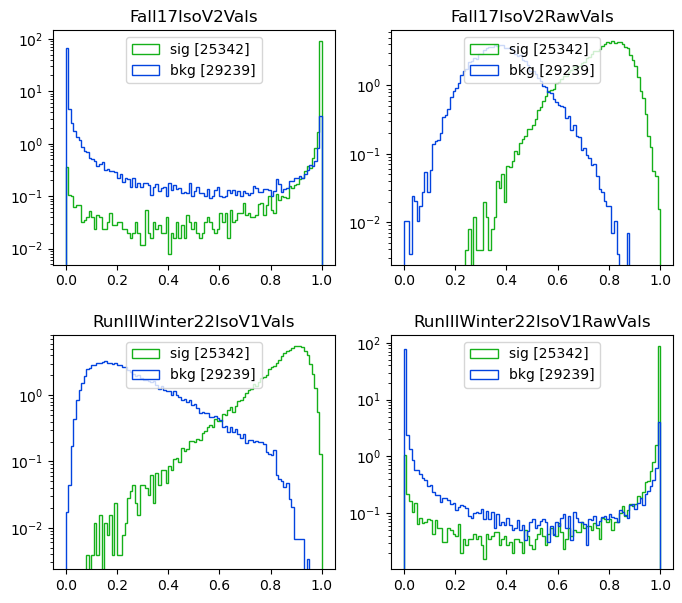

In [5]:
fig2, ax2 = plt.subplots(2,2,figsize=(8,7))
ax2 = ax2.flatten()
fig2.subplots_adjust(hspace=0.3)

bins_=np.arange(0, 1.01, 0.01)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
#fig2.suptitle('MVA scores') #Global title

varmva = ['MVA1','MVA2','MVA3','MVA4']

for i in range(len(varmva)):
    ax2[i].hist(df[df['truth']==1][varmva[i]], bins=bins_, histtype='step',
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax2[i].hist(df[df['truth']==0][varmva[i]], bins=bins_, histtype='step',
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax2[i].set_title(alias[varmva[i]])
    ax2[i].set_yscale('log')
    ax2[i].legend(loc='upper center')
    
#ax2[-1].text(0, 1, text, transform=ax2[-1].transAxes, fontsize=10, ha='left', va='top')
#ax2[-1].axis('off')

plt.savefig('plots/all_mva_scores.png', dpi=300)
plt.show()

### ROC for the DNN scores and the MVA IDs without ant pT/eta selection

In [6]:
#ROC calculation:
from sklearn.metrics import roc_curve,auc

true = df['truth'] #Either 0, or 1

ROC_dict ={
    "score1":{},
    "score2":{},
    "score3":{},
    "score4":{},
    "score5":{},
    "MVA1":{},
    "MVA2":{},
    "MVA3":{},
    "MVA4":{},
}

def find_tpr_fnr_auc(true, pred):
    fpr, tpr, _ = roc_curve(true, pred)
    auc_score   = auc(tpr,1-fpr)
    tpr=tpr*100
    fnr=(1-fpr)*100
    return fnr, tpr, auc_score

for score, scoredict in ROC_dict.items():
    fnr, tpr, auc_score = find_tpr_fnr_auc(true, df[score])
    scoredict["fnr"] = fnr
    scoredict["tpr"] = tpr
    scoredict["auc"] = auc_score
    
#Sorting it according to AUC
import collections
ROC_dict = collections.OrderedDict(sorted(ROC_dict.items(), key=lambda x: x[1]["auc"], reverse=True))

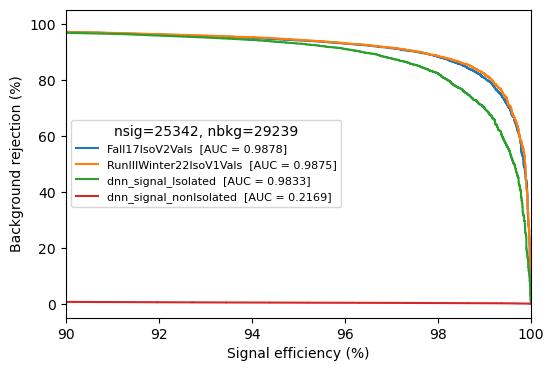

In [7]:
fig3, ax3 = plt.subplots(1,1,figsize=(6,4))

#make plots for only the following:
plots=[
    'dnn_signal_Isolated',
    'dnn_signal_nonIsolated',
    'Fall17IsoV2Vals',
    #'Fall17IsoV2RawVals',
    'RunIIIWinter22IsoV1Vals',
    #'RunIIIWinter22IsoV1RawVals'
]

for score, scoredict in ROC_dict.items():
    for plot in plots:
        if(plot == alias[score]):
            tpr = scoredict["tpr"]
            fnr = scoredict["fnr"]
            auc = scoredict["auc"]
            label_ = alias[score]+f'  [AUC = {auc:.4f}]'
            ax3.plot(tpr,fnr, label=label_)

threshold = 0.80
nsig = df[df['truth']==1].shape[0]
nsigpass = df[(df['truth']==1) & (df['score1']+df['score2']>threshold)].shape[0]
sigeff = (nsigpass/nsig)*100
nbkg = df[df['truth']==0].shape[0]
nbkgfail = df[(df['truth']==0) & (df['score1']+df['score2']<threshold)].shape[0]
bkgrej = (nbkgfail/nbkg)*100
#plt.plot(sigeff, bkgrej, marker='o', color="red", markersize=6, label=f'Current DNN wp ~ {sigeff:.0f},{bkgrej:.0f}')
legendheader = f'nsig={nsig}, nbkg={nbkg}'

ax3.set_xlabel('Signal efficiency (%)')
ax3.set_xlim(90, 100)
#ax3.set_xscale('log')
ax3.set_ylabel('Background rejection (%)')
ax3.legend(loc='center left', prop={"size":8}, title=legendheader, fontsize='samll')

plt.savefig(f'plots/all_roc.png', dpi=300)
plt.show()

---
---

# Further studies:

Let's pick a working point for the DNN node1.

In [8]:
wp1_sigeff_target = 95 #(say)

#We need to scan the DNN score at different values and see which one is closest.
thresholds = np.arange(0, 1.0, 0.001)

diff = 1000
wp1 = None

for val in thresholds:
    nsig = df[df['truth']==1].shape[0]
    nsig_pass = df[(df['truth']==1) & (df['score1']>val)].shape[0]
    sigeff_val = nsig_pass*100/nsig
    diff = sigeff_val - wp1_sigeff_target
    if diff<0:
        print(f'Closest WP I could find = {val:.3f} with sig eff = {sigeff_val:.2f}%')
        wp1 = val
        break
        
#Adding a new flag in the dataframe with the fixed wp
df.loc[df['score1']>wp1, 'wp1']=True
df.loc[df['score1']<wp1, 'wp1']=False
#df[['sample','ele_pt','ele_eta', 'score1', 'wp1','truth']]

sigeff_wp1 = df.loc[(df['truth']==1) & (df['wp1']==True)].shape[0]*100/df[df['truth']==1].shape[0]
bkgrej_wp1 = df.loc[(df['truth']==0) & (df['wp1']==False)].shape[0]*100/df[df['truth']==0].shape[0]
print(f'At the working point {wp1:.3f}, sigeff={sigeff_wp1:.2f}%, bkgrej={bkgrej_wp1:.2f}%')

df

Closest WP I could find = 0.118 with sig eff = 94.97%
At the working point 0.118, sigeff=94.97%, bkgrej=92.93%


,ele_pt,ele_eta,genmatch,score1,score2,score3,score4,score5,MVA1,MVA2,MVA3,MVA4,sample,truth,wp1
0,40.439617,1.981293,1,0.387225,0.008972,0.009412,0.571369,0.023022,0.999790,0.687464,0.701817,9.987190e-01,drellyan,1.0,True
1,13.429829,-0.076164,3,0.003292,0.798330,0.130965,0.065857,0.001558,0.597433,0.520986,0.292389,1.190603e-04,ttbar,0.0,False
2,17.911089,-1.247254,0,0.000003,0.283833,0.710252,0.005754,0.000159,0.000001,0.231197,0.065023,2.980232e-08,ttbar,0.0,False
3,18.851597,-2.488719,1,0.106851,0.007877,0.032941,0.141596,0.710735,0.911626,0.560965,0.602053,8.011663e-02,drellyan,1.0,False
4,7.807203,1.694718,0,0.081744,0.070374,0.375367,0.246328,0.226187,0.001862,0.383263,0.343200,1.179576e-04,drellyan,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54576,32.045979,-2.398405,1,0.967014,0.011574,0.000101,0.005472,0.015839,0.999999,0.804865,0.895622,9.999914e-01,drellyan,1.0,True
54577,26.854452,0.708809,2,0.978750,0.004439,0.000249,0.010316,0.006247,1.000000,0.850003,0.941640,9.999997e-01,ttbar,1.0,True
54578,31.186710,-1.648195,1,0.956273,0.013535,0.000735,0.015748,0.013709,0.999931,0.710374,0.782936,9.997420e-01,drellyan,1.0,True
54579,36.228466,0.931991,1,0.965214,0.001719,0.000215,0.004908,0.027945,0.999996,0.768223,0.921885,9.999992e-01,drellyan,1.0,True


### Given that a candidate passes WP1, how often it passes/fails the other DNN nodes:

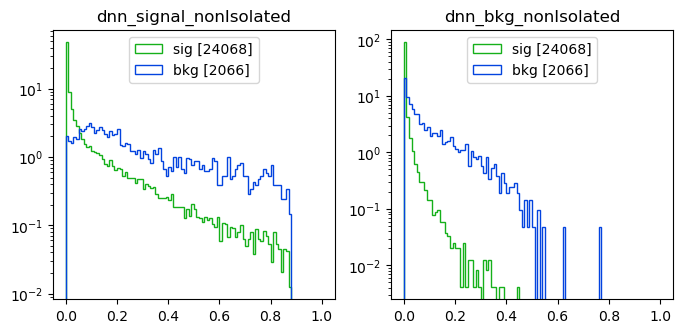

In [9]:
dfwp1 = df[df['wp1']==True]
nsigwp1 = dfwp1[dfwp1['truth']==1].shape[0]
nbkgwp1 = dfwp1[dfwp1['truth']==0].shape[0]

#Plotting:
fig4, ax4 = plt.subplots(1,2,figsize=(8,3.5))
ax4 = ax4.flatten()
fig4.subplots_adjust(hspace=0.5)
bins_=np.arange(0, 1.01, 0.01)

#DNN node2 score:
ax4[0].hist(dfwp1[dfwp1['truth']==1]['score2'], bins=bins_, histtype='step',
            color='xkcd:green',  label=f'sig [{nsigwp1}]', density=True)
ax4[0].hist(dfwp1[dfwp1['truth']==0]['score2'], bins=bins_, histtype='step',
            color='xkcd:blue',  label=f'bkg [{nbkgwp1}]', density=True)
ax4[0].set_title(alias['score2'])
ax4[0].set_yscale('log')
ax4[0].legend(loc='upper center')

#DNN node3 score:
ax4[1].hist(dfwp1[dfwp1['truth']==1]['score3'], bins=bins_, histtype='step',
            color='xkcd:green',  label=f'sig [{nsigwp1}]', density=True)
ax4[1].hist(dfwp1[dfwp1['truth']==0]['score3'], bins=bins_, histtype='step',
            color='xkcd:blue',  label=f'bkg [{nbkgwp1}]', density=True)
ax4[1].set_title(alias['score3'])
ax4[1].set_yscale('log')
ax4[1].legend(loc='upper center')

plt.savefig('plots/wp1_dnn_scores.png', dpi=300)
plt.show()

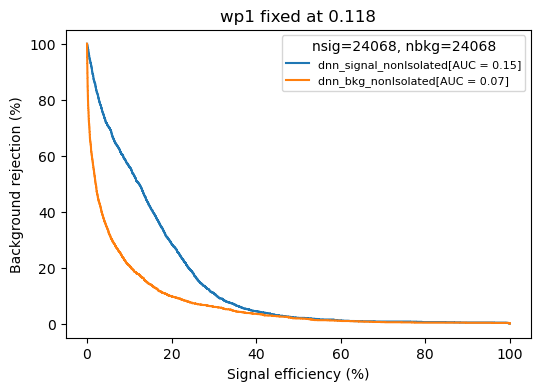

In [10]:
from sklearn.metrics import roc_curve,auc

fig5, ax5 = plt.subplots(1,1,figsize=(6,4))

#Calculating the new ROCs for score2 and score3:
wp1_dict={}
scores=['score2', 'score3']

for score in scores:
    fnr, tpr, auc_score = find_tpr_fnr_auc(dfwp1['truth'], dfwp1[score])
    ax5.plot(tpr,fnr, label=alias[score]+f'[AUC = {auc_score:.2f}]')
    
ax5.set_title(f'wp1 fixed at {wp1:.3f}')    
ax5.set_xlabel('Signal efficiency (%)')
#ax5.set_xlim(90, 100)
#ax5.set_xscale('log')

nsigwp1=dfwp1[dfwp1['truth']==1].shape[0]
nbkgwp1=dfwp1[dfwp1['truth']==1].shape[0]
legendheader = f'nsig={nsigwp1}, nbkg={nbkgwp1}'

ax5.set_ylabel('Background rejection (%)')
ax5.legend(loc='upper right', prop={"size":8}, title=legendheader, fontsize='samll')

plt.savefig('plots/wp1_ROC.png', dpi=300)
plt.show()

### Deciding working points for the other nodes:

By looking at the ROC above, we can choose some WP with higher value of background rejection.<br>
Let's do it for score2.

In [11]:
wp2_bkgrej_target = 60 #say

#We need to scan the DNN score at different values and see which one is closest.
#Let's look at all the values of sigeff and bkgrej first.
thresholds = np.arange(0, 1.0, 0.1)

diff = 1000
wp2 = None

for val in thresholds:
    nsig = dfwp1[dfwp1['truth']==1].shape[0]
    nsig_pass = dfwp1[(dfwp1['truth']==1) & (dfwp1['score1']>val)].shape[0]
    sigeff_val = nsig_pass*100/nsig
    
    nbkg = dfwp1[dfwp1['truth']==0].shape[0]
    nbkg_fail = dfwp1[(dfwp1['truth']==0) & (dfwp1['score2']<val)].shape[0]
    bkgrej_val = nbkg_fail*100/nsig
    
    diff = bkgrej_val - wp2_bkgrej_target
    print(f'wp2:{val:.3f}, sigeff={sigeff_val:.2f}%, bkgrej={bkgrej_val:.2f}%')
    if diff>0:
        print(f'Closest WP I could find = {val:.3f} with bkg rej = {bkgrej_val:.2f}%')
        wp2 = val
        break

wp2:0.000, sigeff=100.00%, bkgrej=0.00%
wp2:0.100, sigeff=100.00%, bkgrej=1.94%
wp2:0.200, sigeff=98.03%, bkgrej=3.98%
wp2:0.300, sigeff=95.75%, bkgrej=5.21%
wp2:0.400, sigeff=92.94%, bkgrej=6.06%
wp2:0.500, sigeff=89.23%, bkgrej=6.75%
wp2:0.600, sigeff=84.46%, bkgrej=7.38%
wp2:0.700, sigeff=78.22%, bkgrej=7.92%
wp2:0.800, sigeff=69.53%, bkgrej=8.33%
wp2:0.900, sigeff=55.12%, bkgrej=8.58%


# pT eta bins:
Let's plot pT and eta of all the candidates:

In [12]:
df[['ele_pt', 'ele_eta', 'sample', 'truth']]

,ele_pt,ele_eta,sample,truth
0,40.439617,1.981293,drellyan,1.0
1,13.429829,-0.076164,ttbar,0.0
2,17.911089,-1.247254,ttbar,0.0
3,18.851597,-2.488719,drellyan,1.0
4,7.807203,1.694718,drellyan,0.0
...,...,...,...,...
54576,32.045979,-2.398405,drellyan,1.0
54577,26.854452,0.708809,ttbar,1.0
54578,31.186710,-1.648195,drellyan,1.0
54579,36.228466,0.931991,drellyan,1.0


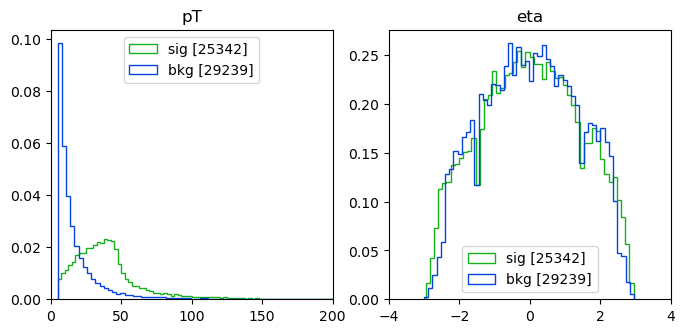

In [13]:
fig6, ax6 = plt.subplots(1,2,figsize=(8,3.5))
ax6 = ax6.flatten()
fig6.subplots_adjust(hspace=0.5)
nptbins =200
netabins=50

nsig=df[df['truth']==1].shape[0]
nbkg=df[df['truth']==0].shape[0]

ax6[0].hist(df[df['truth']==1]['ele_pt'], bins=nptbins, histtype='step',
            color='xkcd:green',  label=f'sig [{nsig}]', density=True)
ax6[0].hist(df[df['truth']==0]['ele_pt'], bins=nptbins, histtype='step',
            color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
ax6[0].set_title('pT')
ax6[0].set_xlim(0, nptbins)
#ax6[0].set_yscale('log')
ax6[0].legend(loc='upper center')

ax6[1].hist(df[df['truth']==1]['ele_eta'], bins=netabins, histtype='step',
            color='xkcd:green',  label=f'sig [{nsig}]', density=True)
ax6[1].hist(df[df['truth']==0]['ele_eta'], bins=netabins, histtype='step',
            color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
ax6[1].set_title('eta')
ax6[1].set_xlim(-4, 4)
#ax6[1].set_yscale('log')
ax6[1].legend(loc='lower center')

plt.show()

Let's split the original dataframe into pT/eta bins.<br>
- For eta bins, I choose barrel (`abs(eta)<1.442`) and endcap (`abs(eta)>1.442`)<br>
- For pT bins, I choose `pt<30`, `30<pt<70` and `pt>70`

In [14]:
df.loc[df['ele_pt'] < 30, 'ptbin'] = 'lowpt'
df.loc[(30 < df['ele_pt']) & (df['ele_pt'] < 70), 'ptbin'] = 'medpt'
df.loc[70 < df['ele_pt'], 'ptbin'] = 'highpt'

df.loc[df['ele_eta'] < 1.442, 'etabin'] = 'barrel'
df.loc[df['ele_eta'] > 1.442, 'etabin'] = 'endcap'

nlowbar = df[(df['ptbin']=='lowpt') & (df['etabin']=='barrel')].shape[0]
nmedbar = df[(df['ptbin']=='medpt') & (df['etabin']=='barrel')].shape[0]
nhigbar = df[(df['ptbin']=='highpt') & (df['etabin']=='barrel')].shape[0]
nlowend = df[(df['ptbin']=='lowpt') & (df['etabin']=='endcap')].shape[0]
nmedend = df[(df['ptbin']=='medpt') & (df['etabin']=='endcap')].shape[0]
nhigend = df[(df['ptbin']=='highpt') & (df['etabin']=='endcap')].shape[0]

df[['ele_pt', 'ele_eta', 'sample', 'truth', 'ptbin', 'etabin']]
print(f'Number of candidates in the pt-eta bins :')

print("pt\tbarrel\tendcap")
print("low\t{}\t{}".format(nlowbar, nlowend))
print("med\t{}\t{}".format(nmedbar, nmedend))
print("high\t{}\t{}".format(nhigbar, nhigend))

Number of candidates in the pt-eta bins :
pt	barrel	endcap
low	28151	6108
med	13636	3132
high	3064	490


### Plotting DNN and MVA scores in each pt/eta bin

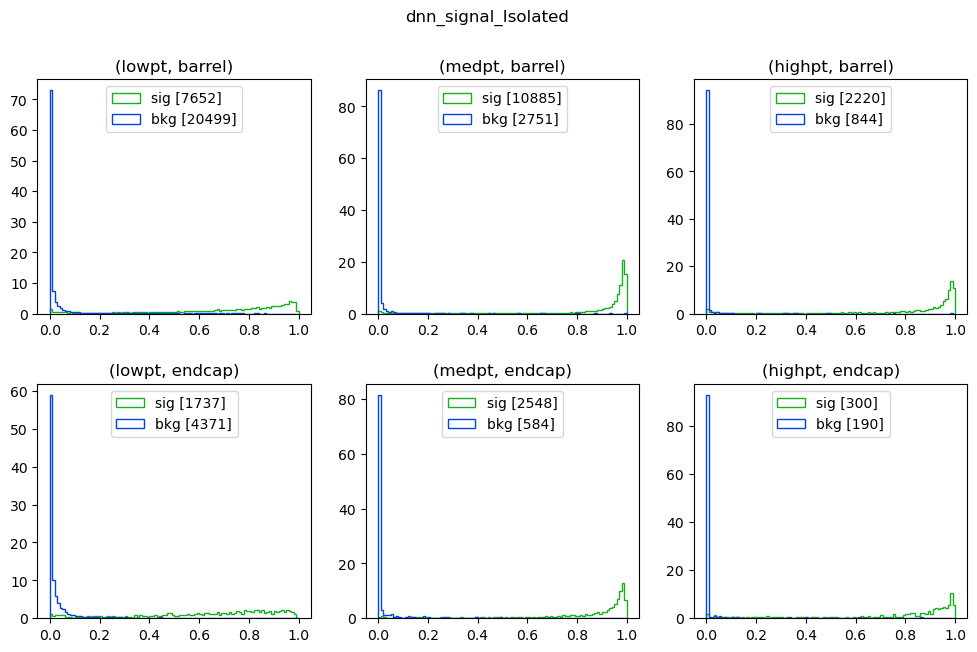

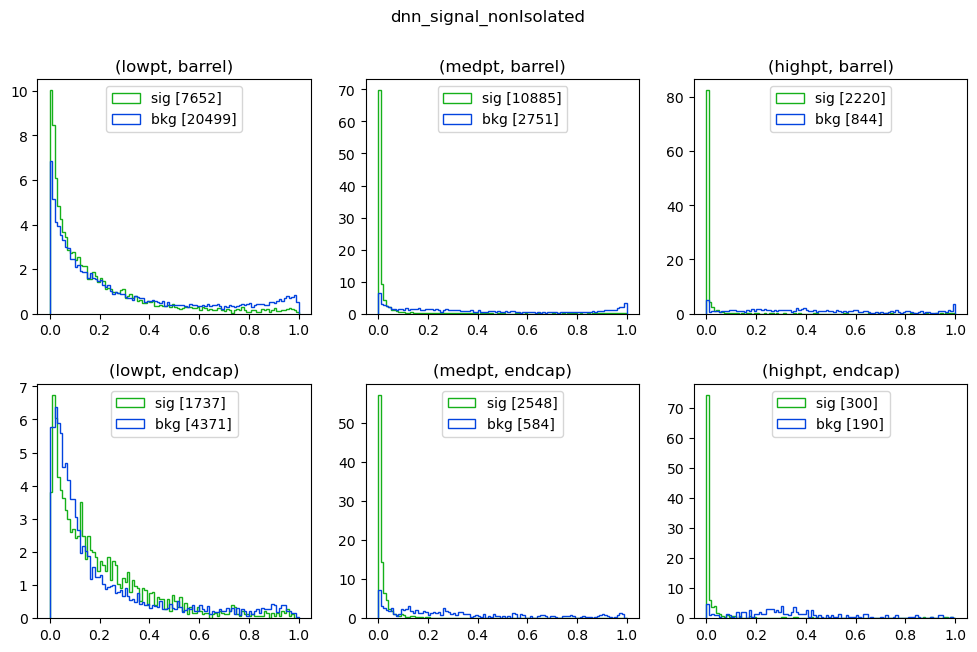

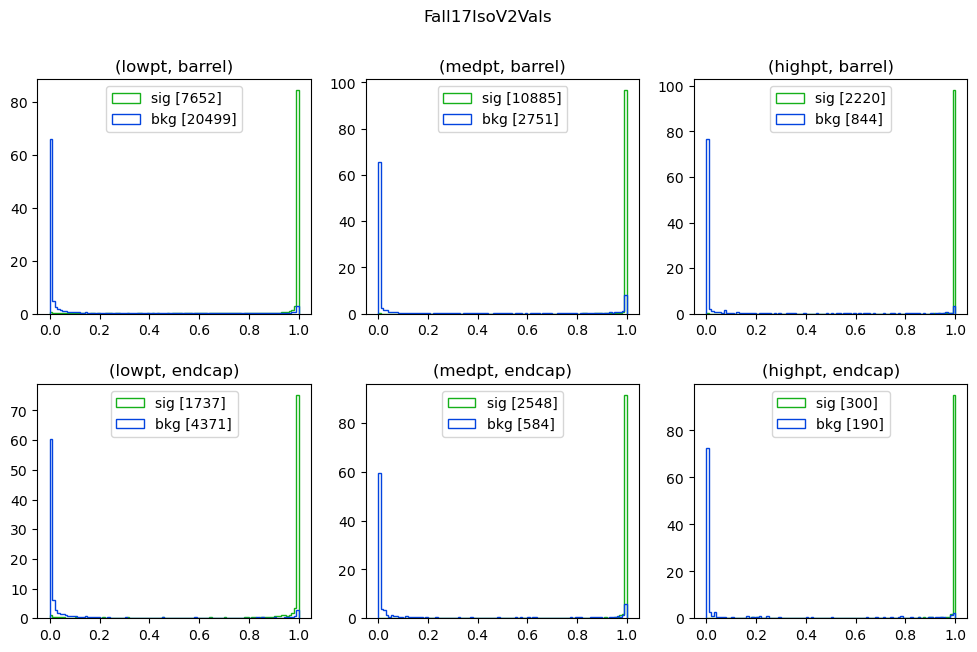

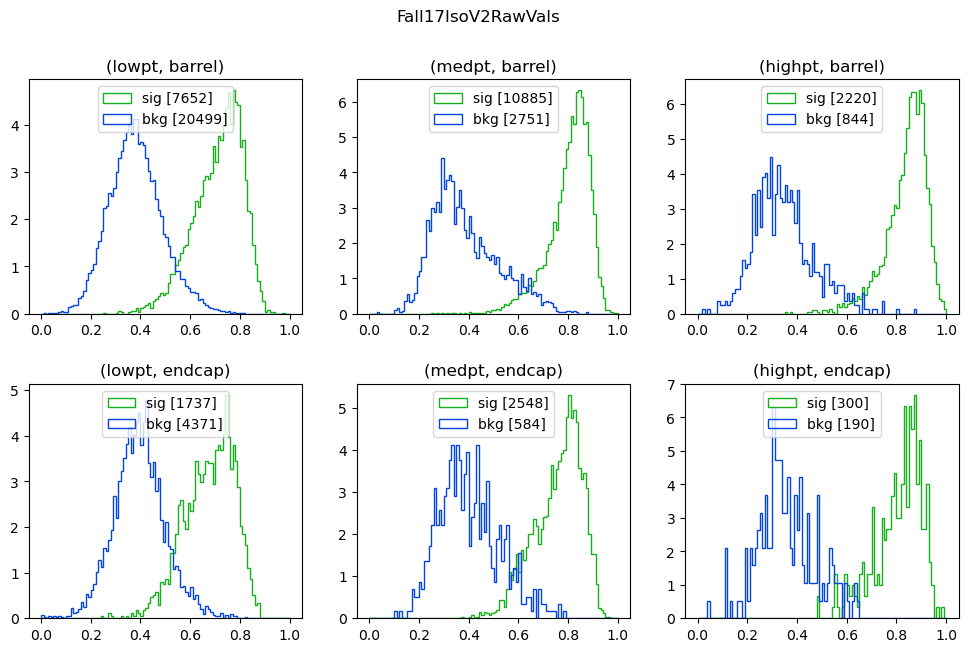

In [15]:
scores = ['score1', 'score2', 'MVA1', 'MVA2']
bins_=np.arange(0, 1.01, 0.01)

for score in scores:
    fig7, ax7 = plt.subplots(2,3,figsize=(12,7))
    ax7 = ax7.flatten()
    fig7.subplots_adjust(hspace=0.3)
    fig7.suptitle(alias[score])
    ptbins = ['lowpt', 'medpt', 'highpt']
    
    #Barrel plots:
    for i in [0, 1, 2]:
        sigfilter = (df['truth']==1) & (df['ptbin']==ptbins[i]) & (df['etabin']=='barrel')
        bkgfilter = (df['truth']==0) & (df['ptbin']==ptbins[i]) & (df['etabin']=='barrel')
        nsig_ptetabin = df[sigfilter].shape[0]
        nbkg_ptetabin = df[bkgfilter].shape[0]        
        ax7[i].hist(df[sigfilter][score],bins=bins_, histtype='step', color='xkcd:green',  label=f'sig [{nsig_ptetabin}]', density=True)
        ax7[i].hist(df[bkgfilter][score],bins=bins_, histtype='step', color='xkcd:blue',  label=f'bkg [{nbkg_ptetabin}]', density=True)
        ax7[i].set_title(f'({ptbins[i]}, barrel)')
        #ax7[i].set_yscale('log')
        ax7[i].legend(loc='upper center')
    
    #endcap plots:
    for i in [3, 4, 5]:
        sigfilter = (df['truth']==1) & (df['ptbin']==ptbins[i-3]) & (df['etabin']=='endcap')
        bkgfilter = (df['truth']==0) & (df['ptbin']==ptbins[i-3]) & (df['etabin']=='endcap')
        nsig_ptetabin = df[sigfilter].shape[0]
        nbkg_ptetabin = df[bkgfilter].shape[0]        
        ax7[i].hist(df[sigfilter][score],bins=bins_, histtype='step', color='xkcd:green',  label=f'sig [{nsig_ptetabin}]', density=True)
        ax7[i].hist(df[bkgfilter][score],bins=bins_, histtype='step', color='xkcd:blue',  label=f'bkg [{nbkg_ptetabin}]', density=True)
        ax7[i].set_title(f'({ptbins[i-3]}, endcap)')
        #ax7[i].set_yscale('log')
        ax7[i].legend(loc='upper center')
        
    plt.savefig(f'plots/ptetabins_{score}.png', dpi=300)
    plt.show()

### Plotting ROCs in each pt/eta bin:

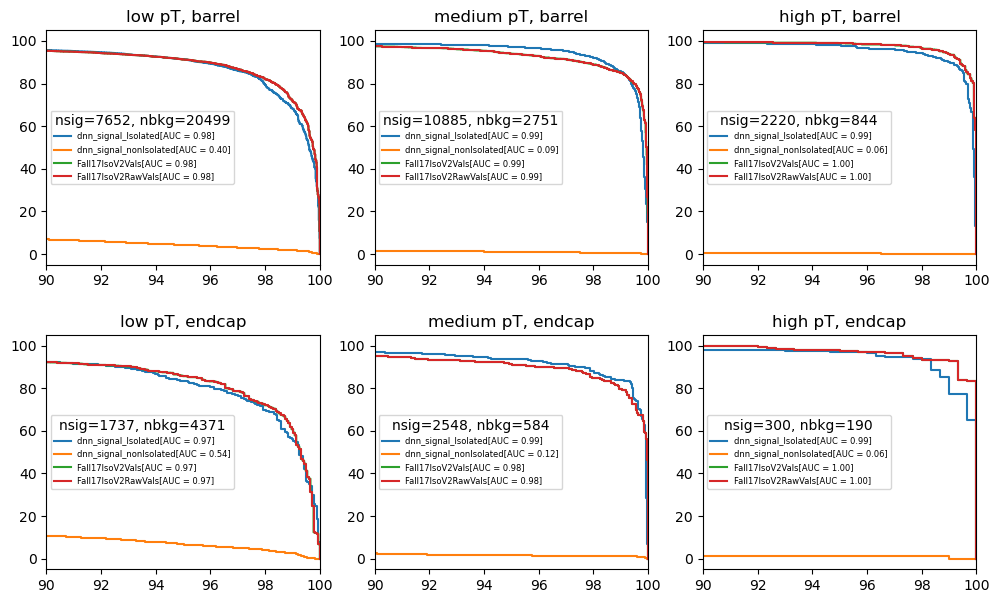

In [16]:
from sklearn.metrics import roc_curve,auc
scores = ['score1', 'score2', 'MVA1', 'MVA2']

fig8, ax8 = plt.subplots(2,3,figsize=(12,7))
ax8 = ax8.flatten()
fig8.subplots_adjust(hspace=0.3)
index = 0

ptetabins = {
    "low pT, barrel"    :(df['ptbin']=='lowpt') & (df['etabin']=='barrel'),
    "medium pT, barrel" :(df['ptbin']=='medpt') & (df['etabin']=='barrel'),
    "high pT, barrel"   :(df['ptbin']=='highpt') & (df['etabin']=='barrel'),
    "low pT, endcap"    :(df['ptbin']=='lowpt') & (df['etabin']=='endcap'),
    "medium pT, endcap" :(df['ptbin']=='medpt') & (df['etabin']=='endcap'),
    "high pT, endcap"   :(df['ptbin']=='highpt') & (df['etabin']=='endcap')
}

for binname, binfilter in ptetabins.items():
    for score in scores:
        fnr, tpr, auc_score = find_tpr_fnr_auc(df[binfilter]['truth'], df[binfilter][score])
        ax8[index].plot(tpr,fnr, label=alias[score]+f'[AUC = {auc_score:.2f}]')
     
    nsig_ptetabin = df[binfilter & (df['truth']==1)].shape[0]
    nbkg_ptetabin = df[binfilter & (df['truth']==0)].shape[0]
    legendheader = f'nsig={nsig_ptetabin}, nbkg={nbkg_ptetabin}'
    
    ax8[index].set_title(f'{binname}')
    ax8[index].set_xlim(90, 100)
    #ax8[index].set_yscale('log')
    ax8[index].legend(loc='center left', prop={"size":6}, title=legendheader, fontsize='small')
    index=index+1

plt.savefig(f'plots/ptetabins_ROC.png', dpi=300)
plt.show()